In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('screen', String, primary_key = True)
                
        
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('vote', Integer)
                  )

# Create the above tables
# meta.create_all(con)

In [5]:
def plot_market_trend(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    s = select([mkt_trend]).\
        where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date >= start_date, mkt_trend.c.date <= date, mkt_trend.c.screen == 1)).\
        order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
    ax.bar(mkt_trend_df.date.values, mkt_trend_df.dif_current.values, color = 'red')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [6]:
def plot_market_trend_hist(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    s = select([mkt_trend]).\
        where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date >= start_date, mkt_trend.c.date <= date, mkt_trend.c.screen == 1)).\
        order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    print(len(mkt_trend_df))
    fig, ax = plt.subplots()
    ax.hist(mkt_trend_df.dif_current.values, bins = 25)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.show()
    
# plot_screen('BTC', 60)

EXAMPLE OF SAVE

In [19]:
def plot_screen(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    s = select([tickers]).\
        where(and_(tickers.c.coin == coin, tickers.c.date >= start_date, tickers.c.date <= date, tickers.c.screen == 0)).\
        order_by(desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    tickers_df.columns = rows.keys()
    
    s = select([ema]).\
        where(and_(ema.c.coin == coin, ema.c.date >= start_date, ema.c.date <= date, ema.c.screen == 1)).\
        order_by(desc(ema.c.date))
        
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    ema_df.columns = rows.keys()
    
    s = select([boillinger]).\
        where(and_(boillinger.c.coin == coin, boillinger.c.date >= start_date, boillinger.c.date <= date, boillinger.c.screen == 1)).\
        order_by(desc(boillinger.c.date))
    rows = con.execute(s)
    boillinger_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    boillinger_df.columns = rows.keys()
    
    s = select([long_positions]).\
        where(and_(long_positions.c.coin == coin, long_positions.c.date_ask >= start_date, long_positions.c.date_ask <= date)).\
        order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    long_df.columns = rows.keys()
    
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
    ax.plot(tickers_df.date.values, tickers_df.price.values, color = 'green')
    ax.scatter(long_df.date_ask.values, long_df.ask.values, color = 'red')
    ax.scatter(long_df.exit_date.values, long_df.exit_price.values, color = 'blue')
#     ax.scatter(ema_df.date.values, ema_df.ema5.values, color = 'blue')
    ax.plot(boillinger_df.date.values, boillinger_df.upper_band.values)
    ax.plot(boillinger_df.date.values, boillinger_df.lower_band.values)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [20]:
def plot_screen_2(coin,\
                  start_date = datetime.today().strftime('%Y-%m-%d'), \
                  date = datetime.today().strftime('%Y-%m-%d')):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    s = select([ema]).\
        where(and_(ema.c.coin == coin, ema.c.date >= start_date, ema.c.date <= date, ema.c.screen == 1)).\
        order_by(desc(ema.c.date))
    
        
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    ema_df.columns = rows.keys()
    
    
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
    ax.plot(ema_df.date.values, ema_df.ema20.values, color = 'blue')
    ax.plot(ema_df.date.values, ema_df.ema5.values, color = 'red')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [21]:
def plot_screen_3(coin,\
                  start_date = datetime.today().strftime('%Y-%m-%d'), \
                  date = datetime.today().strftime('%Y-%m-%d')):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    s = select([ema]).\
        where(and_(ema.c.coin == coin, ema.c.date >= start_date, ema.c.date <= date, ema.c.screen == 2)).\
        order_by(desc(ema.c.date))
    
        
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    ema_df.columns = rows.keys()
    
    
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
    ax.plot(ema_df.date.values, ema_df.ema20.values, color = 'blue')
    ax.plot(ema_df.date.values, ema_df.ema5.values, color = 'red')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

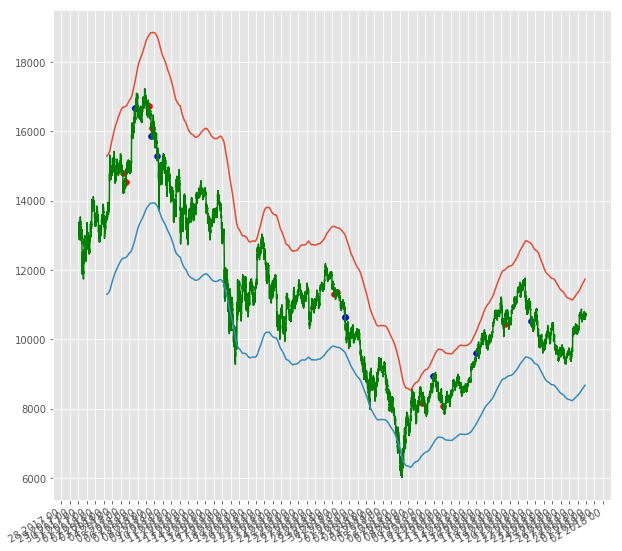

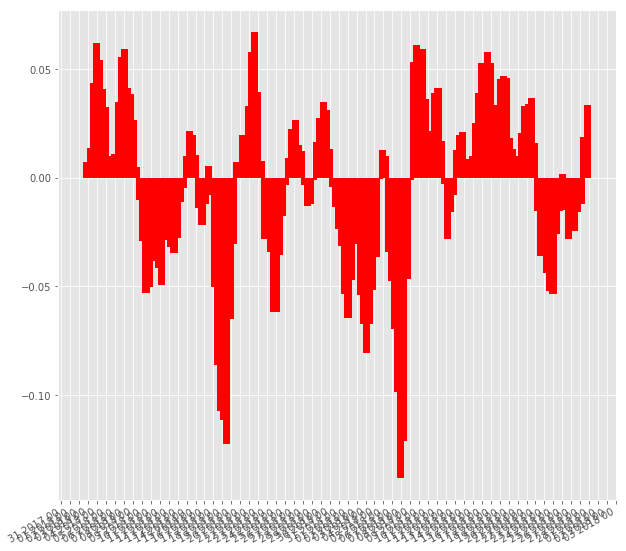

162


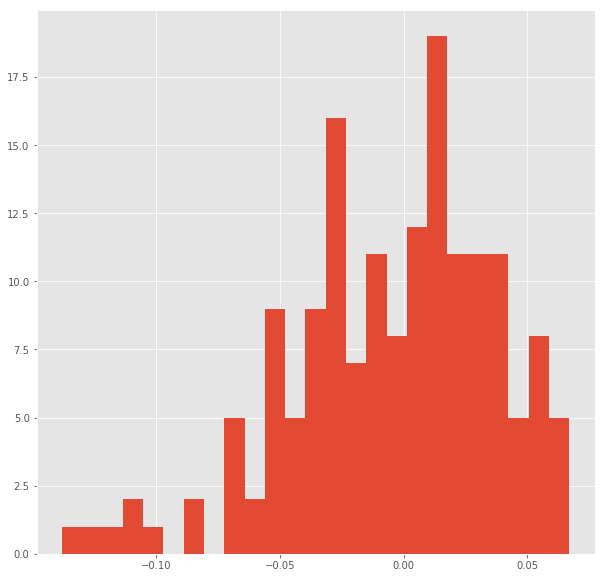

In [22]:
coin = 'USDT_BTC'
start = '2017-01-01'
# stop = '2018-01-15'
plot_screen(coin, start_date = start)
# plot_screen_2(coin, start_date = start)
plot_market_trend(coin, start_date = start)
plot_market_trend_hist(coin, start_date = start)
# plot_screen_3(coin,start_date = start, date = stop)
# plot_screen_3(coin, n)
# plot_screen_4(coin, n)

In [23]:
def log_return(coin):
    s = select([long_positions]).\
        where(and_(long_positions.c.coin == coin, long_positions.c.status  == 'closed')).\
        order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    long_df.columns = rows.keys()
    
    s = select([mkt_trend]).\
        where(and_(mkt_trend.c.coin == coin, mkt_trend.c.screen == 1)).\
        order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current']] 
    
    
    merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
    
    return_total = merged['log_return'].sum()
    print(return_total)
    print(merged)
#     return long_df
    
    
coin = 'USDT_BTC'
log_return(coin)

0.303521755431
   id_position      coin  size_position            date_ask           ask  \
0         1500  USDT_BTC            0.1 2018-01-04 06:15:00  14788.000000   
1         1600  USDT_BTC            0.1 2018-01-04 14:35:00  14534.433288   
2         2400  USDT_BTC            0.1 2018-01-07 09:15:00  16740.000000   
3         2500  USDT_BTC            0.1 2018-01-07 17:35:00  16111.000000   
4         8700  USDT_BTC            0.1 2018-01-29 06:15:00  11322.506265   
5         8800  USDT_BTC            0.1 2018-01-29 14:35:00  11360.000000   
6        11700  USDT_BTC            0.1 2018-02-08 16:15:00   8149.188539   
7        12400  USDT_BTC            0.1 2018-02-11 02:35:00   8069.773516   
8        14500  USDT_BTC            0.1 2018-02-18 09:35:00  10436.954494   

      date_settlement    settlement   take_profit     stop_loss  \
0 2018-02-28 02:08:32  14788.000000  16572.875529  14850.817200   
1 2018-02-28 02:08:32  14534.433288  16567.142909  14850.817200   
2 2018-02-28 

In [24]:
def plot_screen(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    s = select([tickers]).\
        where(and_(tickers.c.coin == coin, tickers.c.date >= start_date, tickers.c.date <= date, tickers.c.screen == 0)).\
        order_by(desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    tickers_df.columns = rows.keys()
    
    s = select([boillinger]).\
        where(and_(boillinger.c.coin == coin, boillinger.c.date >= start_date, boillinger.c.date <= date, boillinger.c.screen == 1)).\
        order_by(desc(boillinger.c.date))
    rows = con.execute(s)
    boillinger_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    boillinger_df.columns = rows.keys()
    

    
# plot_screen('BTC', 60)

## 